### Libraries

In [102]:
#Data Manipulation
import pandas as pd
import numpy as np

#Plots
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
%matplotlib inline
plt.style.use('seaborn-v0_8-darkgrid')

#Utilities
import time
import warnings
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from tqdm import tqdm

#Models
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

warnings.filterwarnings("ignore")
warnings.simplefilter('ignore')
parameters = {
    "dataset":{
        "path": "../data/Processed_Data/Demand_Dataset.csv",
        "trainingSize": .70,
        "validationSize": .15,
        "testSize": .15
    },
    "backtesting":{
        "steps": 96,
        "fixedTrainSize": False,
        "refit": False,
    },
    "validation": {
        "n_splits" : 10
    }
}

In [103]:
def plotDatasetSplit(X_train, X_train_dates, X_test, X_test_dates):
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=X_train_dates, y=X_train["Demand"], mode="lines", name="Train"))
    fig.add_trace(go.Scatter(x=X_test_dates, y=X_test["Demand"], mode="lines", name="Test"))
    fig.update_layout(
        title = "Dataset Partition",
        xaxis_title = "Date",
        yaxis_title ="Demand (MWh)",
        width = 1000,
        height = 400,
        margin = dict(l=30, r=20, t=35, b=60),
        legend = dict(
            orientation = "h",
            yanchor = "bottom",
            y = 1.05,
            xanchor = "right",
            x=1
        )
    )
    fig.show()

In [104]:
def plotPredictions(dates, y_pred, y_test):
    fig = go.Figure()
    trace1 = go.Scatter(x=dates, y=y_test, name="test", mode="lines")
    trace2 = go.Scatter(x=dates, y=y_pred, name="predictions", mode="lines")
    fig.add_trace(trace1)
    fig.add_trace(trace2)
    fig.update_layout(
        title="Real value vs Predicted in Test Data",
        xaxis_title="Date Time",
        yaxis_title="Demand",
        width=1020,
        height=450,
        margin = dict(l=70, r=20, t=55, b=20),
        legend = dict(
            orientation = "h",
            yanchor="top",
            y=1.1,
            xanchor="left",
            x=0.76
        )
    )
    fig.show()

In [105]:
def addNLags(df, lags=1):
    lag_df = df.copy()
    for i in range(1, lags + 1):
        lag_df[f'lag_{i}'] = lag_df['Demand'].shift(i)
    return lag_df.dropna()

## Machine Learning Models

### Split Dataset

In [106]:
df2 = pd.read_csv(parameters["dataset"]["path"], index_col=None)
dates = df2["Date"]
df2 = df2.drop(columns=["Date"])

trainingSize = int((parameters["dataset"]["trainingSize"] + parameters["dataset"]["validationSize"])* df2.shape[0])

X_train = df2.loc[:trainingSize, :].copy()
X_train_dates = dates.loc[:trainingSize].copy()
X_test = df2.loc[trainingSize:, :].copy()
X_test_dates = dates.loc[trainingSize:].copy()

print(f"Training and Validation Size: {trainingSize}")
print(f"Test Size: {len(df2)-trainingSize}")

Training and Validation Size: 59568
Test Size: 10512


In [107]:
plotDatasetSplit(X_train, X_train_dates, X_test, X_test_dates)

### Walking Forward Validation

In [156]:
from sklearn.model_selection import TimeSeriesSplit
def walkForwardValidation(X, y, X_test, y_test, n_splits):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    metrics = []
    model = KNeighborsRegressor(n_neighbors=20, weights='uniform')
    for i, (train_index, eval_index) in enumerate(tscv.split(X)):
        print(X.shape)
        X_train, X_val = X[train_index], X[eval_index]
        y_train, y_val = y[train_index], y[eval_index]
        model.fit(X_train, y_train)

        #Validation Scores
        y_pred_val = model.predict(X_val)
        mae_val = mean_absolute_error(y_val, y_pred_val)
        rmse_val = root_mean_squared_error(y_val, y_pred_val)
        print(f"Validation MAE: {mae_val}, RMSE: {rmse_val}")

        #Test Scores
        y_pred_test = model.predict(X_test)
        mae_test = mean_absolute_error(y_test, y_pred_test)
        rmse_test = root_mean_squared_error(y_test, y_pred_test)
        print(f"Test MAE: {mae_test}, RMSE: {rmse_test}")
        #metrics.append([mae, rmse])
    
    #average_mae = sum(metrics) / len(metrics)


#Standard Scale Numerical Variables
columns = list(X_train.columns)
columns.remove('Demand')
col_preprocessing = ColumnTransformer([
    ('numeric_col_preprocessing', StandardScaler(), columns)
])
pip = Pipeline([('col_preprocessing', col_preprocessing)])

walkForwardValidation(pip.fit_transform(X_train), X_train["Demand"], pip.fit_transform(X_test), X_test["Demand"], 5)

(59569, 24)
Validation MAE: 29.88988718775181, RMSE: 47.65089886635884
Test MAE: 27.982705479452054, RMSE: 43.613080116288884
(59569, 24)
Validation MAE: 32.0812248186946, RMSE: 54.378211437392224
Test MAE: 24.725684931506844, RMSE: 40.07905629408778
(59569, 24)
Validation MAE: 30.582715551974214, RMSE: 46.63108052825794
Test MAE: 24.080136986301365, RMSE: 38.974271750059536
(59569, 24)
Validation MAE: 21.80292103142627, RMSE: 35.32028753454543
Test MAE: 23.396537290715372, RMSE: 38.24786541133494
(59569, 24)
Validation MAE: 23.459649476228847, RMSE: 39.38109261153126
Test MAE: 23.42690258751903, RMSE: 38.027815362548736


### K-Fold Cross Validation

In [95]:
def KFoldCrossValidation(X, y, models, model_names, params):
    results = []
    k = params["validation"]["n_splits"]
    for model, name in tqdm(zip(models, model_names), total=len(models), desc="Models Validation"):
        model_list, mae_list , rmse_list = [name], [], []
        fold_size = len(X) // k
        fold_indices = []
        for i in range(k):
            start_idx = i * fold_size
            end_idx = start_idx + fold_size if i < k - 1 else len(X)

            fold_indices.append((np.arange(start_idx, end_idx), np.concatenate((np.arange(0, start_idx), np.arange(end_idx, len(X))))))

        for fold_idx, (train_idx, test_idx) in enumerate(fold_indices):
            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]

            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            mae_list.append(mean_absolute_error(y_test, y_pred))
            rmse_list.append(root_mean_squared_error(y_test, y_pred))

        model_list.extend(mae_list)
        model_list.extend(rmse_list)
        model_list.extend([np.mean(mae_list), np.mean(rmse_list)])
        results.append(model_list)
    columns = ["model", "k0_mae", "k1_mae", "k2_mae", "k3_mae", "k4_mae", "k5_mae", "k6_mae", "k7_mae", "k8_mae", "k9_mae",
        "k0_rmse", "k1_rmse", "k2_rmse", "k3_rmse", "k4_rmse", "k5_rmse", "k6_rmse", "k7_rmse", "k8_rmse", "k9_rmse", "mae_mean", "rmse_mean"]
    df = pd.DataFrame(results, columns=columns)
    
    return df

In [96]:
#Standard Scale Numerical Variables
columns = list(X_train.columns)
columns.remove('Demand')
col_preprocessing = ColumnTransformer([
    ('numeric_col_preprocessing', StandardScaler(), columns)
])
pip = Pipeline([('col_preprocessing', col_preprocessing)])

models, models_names = [], []

#Tree Models
#for n in [20, 50, 80, 100, 120]:
'''
for n in [20, 50]:
    LGBM = LGBMRegressor(n_estimators=n, random_state=123, verbose=-1)
    XGB = XGBRegressor(n_estimators=n, random_state=123)
    GBM = GradientBoostingRegressor(n_estimators=n, random_state=123)
    models.append(LGBM)
    models_names.append("LGBM_" + str(n))
    models.append(XGB)
    models_names.append("XGB_" + str(n))
    models.append(GBM)
    models_names.append("GBM_" + str(n))
'''

#KNNr
#for n in [10, 20, 30, 40, 50]:
#for n in [10, 20]:
for n in [20]:
    #for weight in ["distance", "uniform"]:
    KNNR = KNeighborsRegressor(n_neighbors=n, weights='uniform')
    models.append(KNNR)
    models_names.append("KNNr_" + str(n) + "_" + 'uniform')
        
#Other Models
models.append(SVR(kernel='rbf'))
models_names.append("SVR")


#Cross Validation
results = KFoldCrossValidation(
    pip.fit_transform(X_train), X_train["Demand"], models, models_names, parameters
)

Models Validation: 100%|██████████| 9/9 [04:58<00:00, 33.12s/it]


In [100]:
results.sort_values(by=["mae_mean", "rmse_mean"])
results.to_csv('../data/Processed_Data/KFold_Validation_Results.csv', index=None)

### Test

In [79]:
def test(X_test2, model):
    X_test = X_test2.copy()
    X_test, y_test = pip.fit_transform(X_test), X_test["Demand"]
    #Predict
    y_pred = model.predict(X_test)

    #Metrics
    mae = mean_absolute_error(y_test, y_pred)
    rmse = root_mean_squared_error(y_test, y_pred)
    return mae, rmse



In [80]:
def checkModelswTest(X_test, models, models_names):
    results = pd.DataFrame(columns=["Model", "MAE_All", "RMSE_All", "MAE_Week", "RMSE_Week","MAE_Day", "RMSE_Day"])
    for model, model_name in tqdm(zip(models, models_names), total=len(models)):
        #Predict All Test
        all_mae, all_rmse = test(X_test, model)
        
        #Predict One Week Test
        week_mae, week_rmse = test(X_test.iloc[:96*7], model)

        #Predict One Day Test
        day_mae, day_rmse = test(X_test.iloc[:96], model)

        results.loc[len(results.index)] = [model_name, all_mae, all_rmse, week_mae, week_rmse, day_mae, day_rmse] 
        
    return results

# Testing
results = checkModelswTest(X_test, models, models_names)
results

100%|██████████| 9/9 [00:05<00:00,  1.54it/s]


Model    MAE_All   RMSE_All   MAE_Week  RMSE_Week    MAE_Day  \
0          LGBM_20  31.697023  45.563698  25.989928  37.990766  33.955809   
1           XGB_20  42.000952  57.018613  39.203600  57.170455  52.623508   
2           GBM_20  28.334157  36.997923  19.689477  23.852206  36.279872   
3          LGBM_50  34.200532  50.013257  28.402503  42.784995  39.773970   
4           XGB_50  41.236246  56.800871  38.564789  56.558577  51.755362   
5           GBM_50  32.766758  41.017908  24.541561  29.981116  38.389618   
6  KNNr_10_uniform  34.037024  53.497277  22.318452  35.453937  22.612500   
7  KNNr_20_uniform  31.757401  49.977776  19.168155  30.456441  23.254167   
8              SVR  29.505348  45.982958  18.832478  25.899825   7.213511   

    RMSE_Day  
0  46.473515  
1  65.211617  
2  41.932486  
3  54.854351  
4  64.347141  
5  43.330084  
6  38.390559  
7  37.912113  
8  10.109244

In [81]:
#All Sort Results
results.sort_values(by=["RMSE_All", "MAE_All"])

Model    MAE_All   RMSE_All   MAE_Week  RMSE_Week    MAE_Day  \
2           GBM_20  28.334157  36.997923  19.689477  23.852206  36.279872   
5           GBM_50  32.766758  41.017908  24.541561  29.981116  38.389618   
0          LGBM_20  31.697023  45.563698  25.989928  37.990766  33.955809   
8              SVR  29.505348  45.982958  18.832478  25.899825   7.213511   
7  KNNr_20_uniform  31.757401  49.977776  19.168155  30.456441  23.254167   
3          LGBM_50  34.200532  50.013257  28.402503  42.784995  39.773970   
6  KNNr_10_uniform  34.037024  53.497277  22.318452  35.453937  22.612500   
4           XGB_50  41.236246  56.800871  38.564789  56.558577  51.755362   
1           XGB_20  42.000952  57.018613  39.203600  57.170455  52.623508   

    RMSE_Day  
2  41.932486  
5  43.330084  
0  46.473515  
8  10.109244  
7  37.912113  
3  54.854351  
6  38.390559  
4  64.347141  
1  65.211617

In [82]:
#Week Sort Results
results.sort_values(by=["RMSE_Week", "MAE_Week"])

Model    MAE_All   RMSE_All   MAE_Week  RMSE_Week    MAE_Day  \
2           GBM_20  28.334157  36.997923  19.689477  23.852206  36.279872   
8              SVR  29.505348  45.982958  18.832478  25.899825   7.213511   
5           GBM_50  32.766758  41.017908  24.541561  29.981116  38.389618   
7  KNNr_20_uniform  31.757401  49.977776  19.168155  30.456441  23.254167   
6  KNNr_10_uniform  34.037024  53.497277  22.318452  35.453937  22.612500   
0          LGBM_20  31.697023  45.563698  25.989928  37.990766  33.955809   
3          LGBM_50  34.200532  50.013257  28.402503  42.784995  39.773970   
4           XGB_50  41.236246  56.800871  38.564789  56.558577  51.755362   
1           XGB_20  42.000952  57.018613  39.203600  57.170455  52.623508   

    RMSE_Day  
2  41.932486  
8  10.109244  
5  43.330084  
7  37.912113  
6  38.390559  
0  46.473515  
3  54.854351  
4  64.347141  
1  65.211617

In [83]:
#Day Sort Results
results.sort_values(by=["RMSE_Day", "MAE_Day"])

Model    MAE_All   RMSE_All   MAE_Week  RMSE_Week    MAE_Day  \
8              SVR  29.505348  45.982958  18.832478  25.899825   7.213511   
7  KNNr_20_uniform  31.757401  49.977776  19.168155  30.456441  23.254167   
6  KNNr_10_uniform  34.037024  53.497277  22.318452  35.453937  22.612500   
2           GBM_20  28.334157  36.997923  19.689477  23.852206  36.279872   
5           GBM_50  32.766758  41.017908  24.541561  29.981116  38.389618   
0          LGBM_20  31.697023  45.563698  25.989928  37.990766  33.955809   
3          LGBM_50  34.200532  50.013257  28.402503  42.784995  39.773970   
4           XGB_50  41.236246  56.800871  38.564789  56.558577  51.755362   
1           XGB_20  42.000952  57.018613  39.203600  57.170455  52.623508   

    RMSE_Day  
8  10.109244  
7  37.912113  
6  38.390559  
2  41.932486  
5  43.330084  
0  46.473515  
3  54.854351  
4  64.347141  
1  65.211617

### Find Best K

In [84]:
def findBestK(X, y, max_k, params):
    final_mae_list, final_rmse_list = [], []
    best_mae, best_rmse, best_k = float('inf'), float('inf'), 0
    
    for k in tqdm(range(1, max_k), total=max_k, desc="Finding Best K..."):
        knn = KNeighborsRegressor(n_neighbors=k, weights='uniform')

        n_splits = params["validation"]["n_splits"]
        mae_list , rmse_list = [], []
        fold_size = len(X) // n_splits
        fold_indices = []
        for i in range(n_splits):
            start_idx = i * fold_size
            end_idx = start_idx + fold_size if i < n_splits - 1 else len(X)

            fold_indices.append((np.arange(start_idx, end_idx), np.concatenate((np.arange(0, start_idx), np.arange(end_idx, len(X))))))

        for fold_idx, (train_idx, test_idx) in enumerate(fold_indices):
            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]

            knn.fit(X_train, y_train)
            y_pred = knn.predict(X_test)
            mae_list.append(mean_absolute_error(y_test, y_pred))
            rmse_list.append(root_mean_squared_error(y_test, y_pred))

        mae, rmse = np.mean(mae_list), np.mean(rmse_list)
        final_mae_list.append(mae)
        final_rmse_list.append(rmse)
        if mae <= best_mae and rmse <= best_rmse:
            best_mae = mae
            best_rmse = rmse
            best_k = k

    #MAE and RMSE plots per k
    fig = make_subplots(rows=2, cols=1, subplot_titles=("MAE Value per K", "RMSE Value per K"))
    fig.append_trace(go.Scatter(x=list(range(1, max_k)), y=final_mae_list, mode='lines'), row=1, col=1)
    fig.append_trace(go.Scatter(x=list(range(1, max_k)), y=final_rmse_list, mode='lines'), row=2, col=1)
    fig.update_xaxes(title_text="K Value", row=1, col=1)
    fig.update_yaxes(title_text="Mean Absolute Error", row=1, col=1)
    fig.update_xaxes(title_text="K Value", row=2, col=1)
    fig.update_yaxes(title_text="Root Mean Squared Error", row=2, col=1)
    fig.update_layout(
        width = 850,
        height = 700,
        margin=dict(l=20, r=20, t=35, b=25),
        showlegend=False
    )
    fig.show()
    print(f"Best K: {best_k}, MAE: {best_mae}, RMSE: {best_rmse}")
    
#findBestK(pip.fit_transform(X_train), X_train["Demand"], 100, parameters)

### Tune Exogenous Variables

Text(0.5, 1.0, 'Pearson Correlation Matrix')

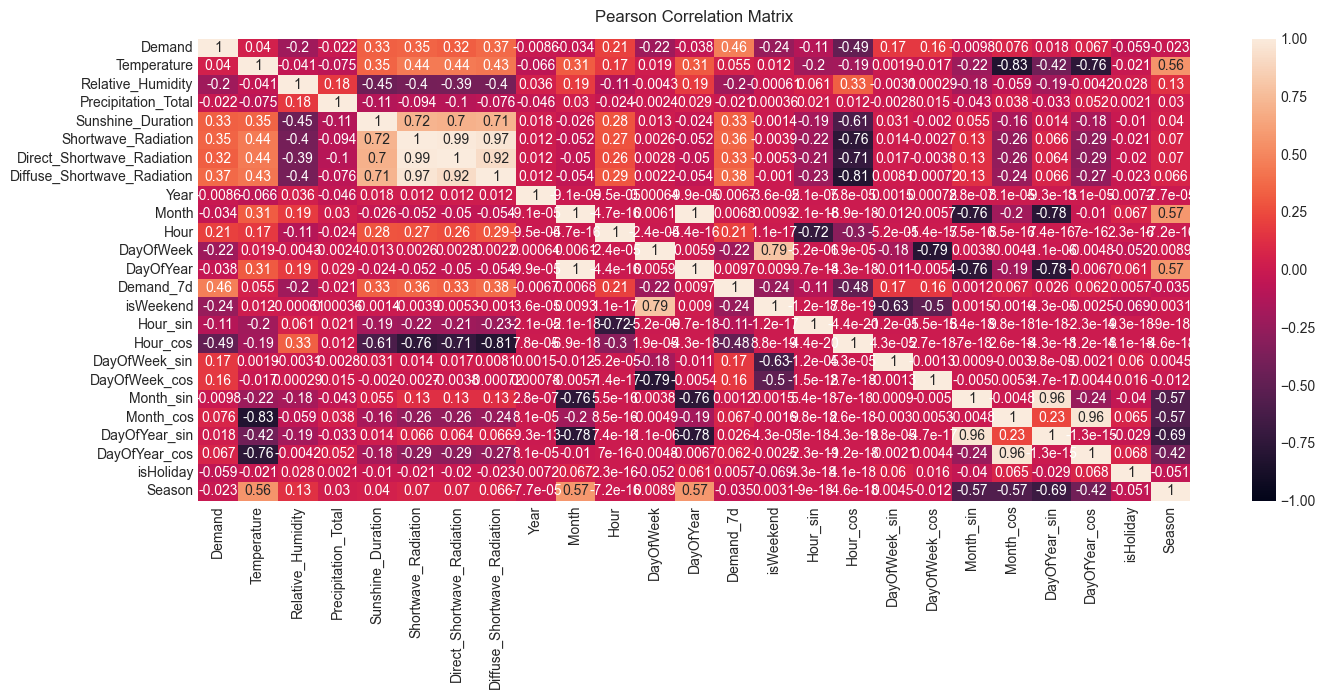

In [85]:
#Correlation Map using Pearson Correlation
plt.figure(figsize=(16,6))
corr_df = pd.read_csv(parameters["dataset"]["path"], index_col=None)
#Drop Columns
corr_df = corr_df.drop(columns=["Date"])
heatmap = sns.heatmap(corr_df.corr('pearson'), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Pearson Correlation Matrix', fontdict={'fontsize': 12}, pad=12)

In [86]:
#columns2drop = ["Minute", "Year"]
#corr_df = corr_df.drop(columns=columns2drop)
trainingSize = int((parameters["dataset"]["trainingSize"] + parameters["dataset"]["validationSize"])* corr_df.shape[0])

X_new_train= corr_df.loc[:trainingSize, :].copy()
X_new_test = corr_df.loc[trainingSize:, :].copy()

new_model = KNeighborsRegressor(n_neighbors=100, weights='uniform')

test(X_train = X_new_train, X_test = X_new_test, model = new_model, type="All")

TypeError: test() got an unexpected keyword argument 'X_train'

### Battery tests

#### Set 12 KWh in Weekends

In [ ]:
df3 = pd.read_csv(parameters["dataset"]["path"], index_col=None)
df3["Demand"][df3.isWeekend == True] = 12
df3["Demand"][df3.Hour < 8] = 12
df3["Demand"][df3.Hour > 20] = 12
dates = df3["Date"]

#Revisar columnas de pipeline
df3 = df3.drop(columns=["Date", "Minute", "Year"], axis=1)
trainingSize = int((parameters["dataset"]["trainingSize"] + parameters["dataset"]["validationSize"])* df3.shape[0])

X_train = df3.loc[:trainingSize, :].copy()
X_train_dates = dates.loc[:trainingSize].copy()
X_test = df3.loc[trainingSize:, :].copy()
X_test_dates = dates.loc[trainingSize:].copy()

model = KNeighborsRegressor(n_neighbors=33, weights='uniform')
test(X_train, X_test, model, "All")

Nº of Days Predicted: 109 == 10512 lags, Test MAE: 16.808553572252205, RMSE: 32.93509162857846
